In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from einops import rearrange
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from mgca.datasets.transforms import DataTransforms
from mgca.constants import *
from mgca.datasets.data_module import DataModule
from mgca.datasets.pretrain_dataset import (MultimodalPretrainingDataset, 
                                            multimodal_collate_fn)
from mgca.models.mgca.mgca_module import MGCA

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
# Load pretrained model
ckpt_path = "../../pretrained/vit_base.ckpt"
model = MGCA.load_from_checkpoint(ckpt_path, strict=False)

In [3]:
# define datamodule
datamodule = DataModule(MultimodalPretrainingDataset, multimodal_collate_fn,
                        DataTransforms, 0.01, 64, 1)

for batch in datamodule.val_dataloader():
    break

In [4]:
with torch.no_grad():
    # Forward of query image encoder
    img_feat_q, patch_feat_q = model.img_encoder_q(
        batch["imgs"])
    patch_emb_q = model.img_encoder_q.local_embed(patch_feat_q)
    patch_emb_q = F.normalize(patch_emb_q, dim=-1)
    img_emb_q = model.img_encoder_q.global_embed(img_feat_q)
    img_emb_q = F.normalize(img_emb_q, dim=-1)

    # Forward of query text encoder
    report_feat_q, word_feat_q, word_attn_q, sents = model.text_encoder_q(
        batch["caption_ids"], batch["attention_mask"], batch["token_type_ids"])
    word_emb_q = model.text_encoder_q.local_embed(word_feat_q)
    word_emb_q = F.normalize(word_emb_q, dim=-1)
    report_emb_q = model.text_encoder_q.global_embed(report_feat_q)
    report_emb_q = F.normalize(report_emb_q, dim=-1)

    # Compute patch attention weights
    bz = img_emb_q.size(0)
    word_atten_output, word_atten = model.word_local_atten_layer(
        word_emb_q, patch_emb_q, patch_emb_q)

In [5]:
print(" ".join([x for x in sents[0] if x != "[PAD]"]))
print(" ".join([x for x in sents[2] if x != "[PAD]"]))
print(" ".join([x for x in sents[4] if x != "[PAD]"]))
print(" ".join([x for x in sents[6] if x != "[PAD]"]))

[CLS] moderate pulmonary edema unchanged interval improvement in right sided pleural effusion the tracheostomy tube is unchanged in position and terminates approximately 8 cm above the carina the right picc line terminates in the distal svc there is no significant change in the lungs when compared to _ _ _ there are several parenchymal calcifications which were characterized on the most recent ct scan again noted are diffuse infiltrative parenchymal opacities right worse than left
[CLS] subtle patchy opacity along the left heart border on the frontal view not substantiated on the lateral view may be due to atelectasis scarring or epicardial fat pad less likely consolidation subtle patchy opacity along the left heart border on the frontal view not substantiated on the lateral view may be due to atelectasis scarring or epicardial fat pad less likely consolidation no focal consolidation seen elsewhere there is no pleural effusion or pneumothorax cardiac and mediastinal silhouettes are sta

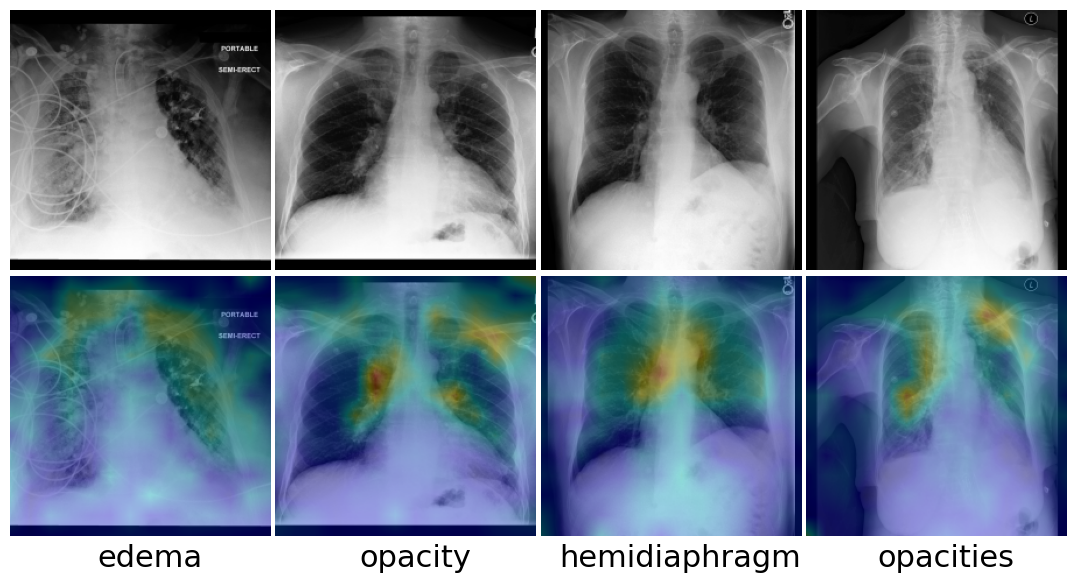

In [6]:
indices = [
    [0, 2],
    [2, 2],
    [3, 2],
    [6, 11]
]

fig, axes = plt.subplots(2, 4)

fig.set_figheight(6)
fig.set_figwidth(11)

for i, (img_idx, word_idx) in enumerate(indices):
    img = (batch["imgs"].cpu().numpy() * 0.5 + 0.5).clip(0, 1)[img_idx].transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)
    axes[0][i].axis("off")
    axes[1][i].axis("off")
    word_atten[img_idx] /= word_atten[img_idx].max()
    atten_map = rearrange(1 - word_atten[img_idx], "b (p1 p2) -> b p1 p2", p1=14, p2=14)
    atten_map = F.interpolate(atten_map.unsqueeze(1), size=[224, 224], mode="bilinear", align_corners=True).squeeze()
    atten_map = (atten_map.detach().cpu().numpy() * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(atten_map[word_idx, ..., None], cv2.COLORMAP_JET)
    axes[0][i].imshow(img)
    axes[1][i].imshow((heatmap * 0.3 + img * 0.6).astype(np.uint8))
    word = sents[img_idx][word_idx+1]
    axes[1][i].text(120, 250, word, fontsize=22, horizontalalignment="center")
plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.1, wspace=0.02, hspace=0.02)